In [1]:
import torch
import os


In [2]:
# large model
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dinov2_vitb14

Using cache found in /work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [4]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [5]:
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt 

patch_size = dinov2_vitb14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14



if torch.cuda.is_available():
  print('Using cuda!')
  device = torch.device("cuda")
  torch.cuda.empty_cache()
  dinov2_vitb14 = dinov2_vitb14.to(device)
else:
  device = torch.device("cpu")

total_features  = []


video_path = "bottle.mp4"

cap = cv2.VideoCapture(video_path)

print("Processing video...")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = img.transpose(Image.ROTATE_270) 

    img_t = transform1(img)
    features_dict = dinov2_vitb14.forward_features(img_t.unsqueeze(0).to(device))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features.detach().cpu())


cap.release() 

print("Finished processing video!")
total_features = torch.cat(total_features, dim=0)
print(total_features.shape)

num_frames = total_features.shape[0]
print('num frames:', num_frames)

Using cuda!
Processing video...
Finished processing video!
torch.Size([231, 1369, 1536])
num frames: 231


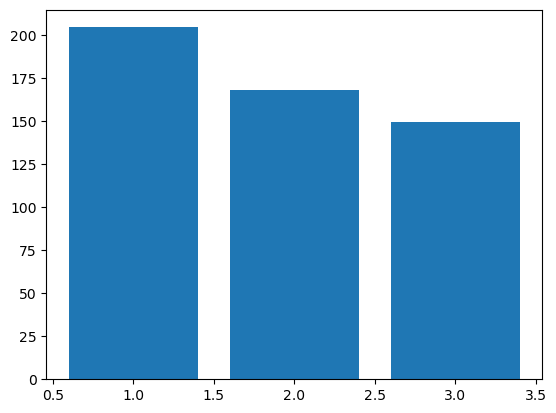

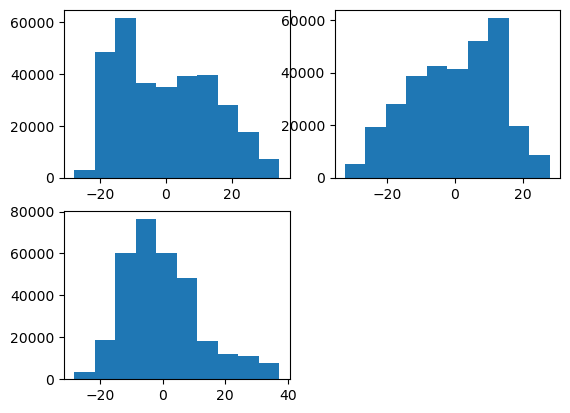

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(num_frames * patch_h * patch_w, feat_dim).cpu() #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)


plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
plt.show()

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

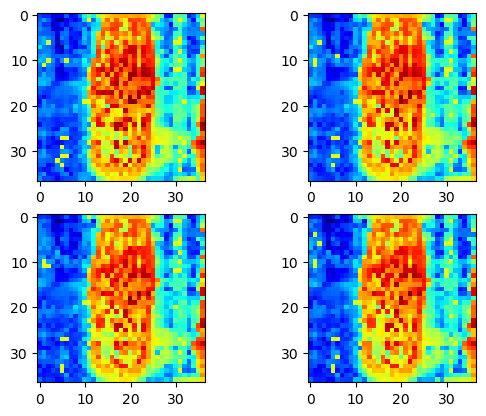

In [7]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w), cmap="jet")

plt.show()

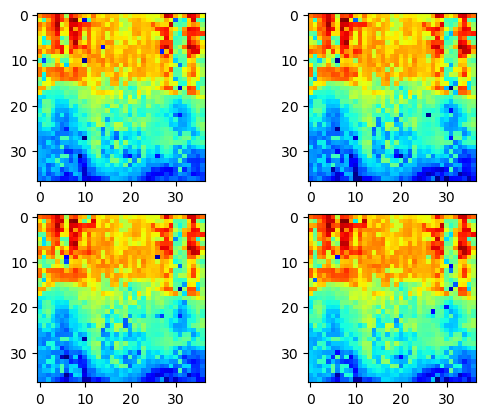

In [8]:
# min_max scale
pca_features_2nd = (pca_features[:, 1] - pca_features[:, 1].min()) / \
                     (pca_features[:, 1].max() - pca_features[:, 1].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_2nd[i*patch_h*patch_w : (i+1)*patch_h*patch_w].reshape(patch_h, patch_w), cmap="jet")

plt.show()

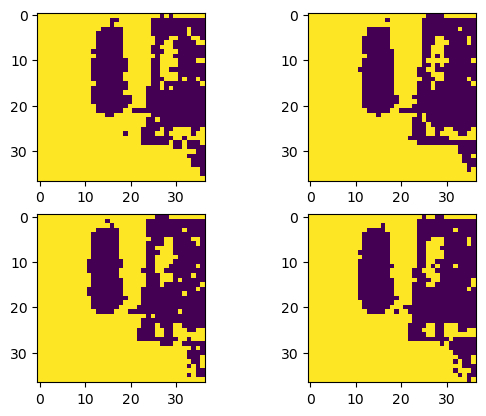

In [9]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = ~((pca_features[:, 0] >= 0.55) & (pca_features[:, 0] <= 1))  # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[(i+100) * patch_h * patch_w: (i+100+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


(231, 37, 37, 3)


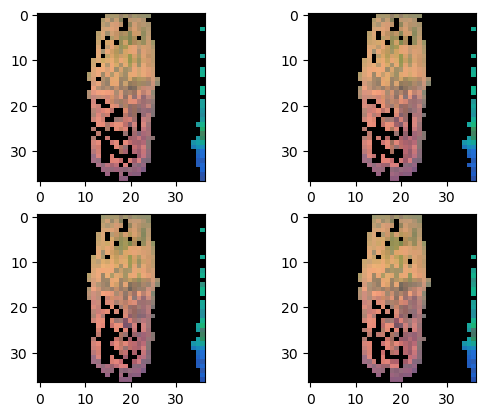

In [10]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg])
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format

pca_features_rgb = pca_features_rgb.reshape(num_frames, patch_h, patch_w, 3)
print(pca_features_rgb.shape)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

# Bounding Box

In [47]:

def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)


# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[3]

if tracker_type == "BOOSTING":
    tracker = cv2.legacy.TrackerBoosting.create()
elif tracker_type == "MIL":
    tracker = cv2.legacy.TrackerMIL.create()
elif tracker_type == "KCF":
    tracker = cv2.TrackerKCF.create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT.create()
elif tracker_type == "TLD":
    tracker = cv2.legacy.TrackerTLD.create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv2.legacy.TrackerMedianFlow.create()
elif tracker_type == "GOTURN":
    tracker = cv2.TrackerGOTURN.create()
else:
    tracker = cv2.legacy.TrackerMOSSE.create()

In [48]:
import numpy as np
# Read video
video = cv2.VideoCapture(video_path)
ok, frame = video.read()

img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
img = img.transpose(Image.ROTATE_270) 
img_t = transform1(img)

img_np = img_t.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
img_np = (img_np * 0.2 + 0.5) * 255  # Reverse normalization
img_np = np.clip(img_np, 0, 255).astype(np.uint8)  # Clip and convert to uint8
frame_transformed = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # Convert back to BGR


    
# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

video_output_file_name = 'bottle' + tracker_type + ".mp4"
video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 30, (width, height))

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


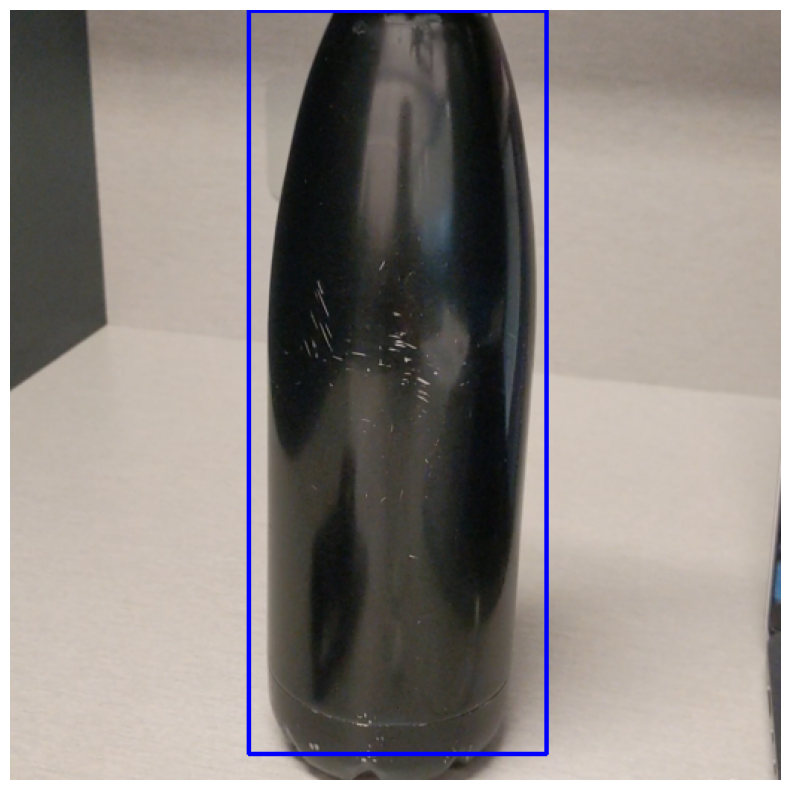

In [49]:
# Define a bounding box
bbox = (160, 0, 200, 500)
# bbox = cv2.selectROI(frame, False)
# print(bbox)
displayRectangle(frame_transformed, bbox)

In [50]:
# Initialize tracker with first frame and bounding box

ok = tracker.init(frame, bbox)

In [51]:
while True:
    ok, frame = video.read()

    if not ok:
        break

    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = img.transpose(Image.ROTATE_270) 
    img_t = transform1(img)

    img_np = img_t.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
    img_np = (img_np * 0.2 + 0.5) * 255  # Reverse normalization
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)  # Clip and convert to uint8
    frame_transformed = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # Convert back to BGR



    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame_transformed)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame_transformed, bbox)
    else:
        drawText(frame_transformed, "Tracking failure detected", (80, 140), (0, 0, 255))

    # Display Info
    drawText(frame_transformed, tracker_type + " Tracker", (80, 60))
    drawText(frame_transformed, "FPS : " + str(int(fps)), (80, 100))

    # Write frame to video
    video_out.write(frame_transformed)

video.release()
video_out.release()

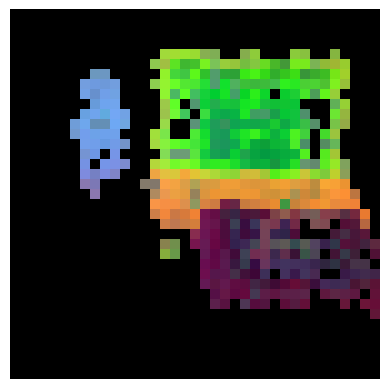

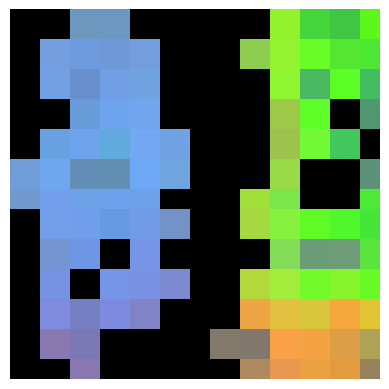

finished


In [24]:
from matplotlib import cm
import numpy as np
from base64 import b64encode
from IPython.display import HTML

#clear output dir
!rm outputPNGS/*

def filter_color(image, lower_bound, upper_bound):
    """
    Filters an image to keep only pixels within the given HSV color bounds.

    Args:
        image (numpy.ndarray): The input image in RGB format.
        lower_bound (tuple): The lower HSV bound (h_min, s_min, v_min).
        upper_bound (tuple): The upper HSV bound (h_max, s_max, v_max).

    Returns:
        numpy.ndarray: The masked image where only the specified color remains.
    """
    # Convert RGB to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Create a binary mask for pixels within the range
    mask = cv2.inRange(hsv_image, np.array(lower_bound), np.array(upper_bound))

    # Apply the mask to keep only the specified color
    filtered_image = cv2.bitwise_and(image, image, mask=mask)

    return filtered_image, mask

def keep_largest_component(mask):
    """
    Keeps only the largest connected component in a binary mask.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # Find the largest component (excluding background label 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # +1 to skip background

    # Create a new mask with only the largest component
    largest_mask = (labels == largest_label).astype(np.uint8) * 255

    return largest_mask

def crop_to_mask(image, mask, output_size=100):
    """
    Crops the image to the bounding box of the mask and resizes it to a fixed size.
    """
    # Find bounding box of the mask
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return np.zeros((output_size, output_size, 3), dtype=np.uint8)
        
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    width = max(x_max-x_min, y_max-y_min, 10)

    # Crop the image
    cropped_image = image[y_min:y_min+width+1, x_min:x_min+width+1]

    
    resized_image = cv2.resize(cropped_image, (output_size, output_size), interpolation=cv2.INTER_NEAREST)
    return resized_image


#HSV values
lower_brown = (100, 50, 100)   # Lower bound for brown
upper_brown = (200, 255, 255) # Upper bound for brown

for i in range(num_frames):
    feature_map = pca_features_rgb[i]
    # feature_map = cm.jet((feature_map - feature_map.min()) / (feature_map.max() - feature_map.min()))[:, :, :3]
    feature_map = (feature_map * 255).astype(np.uint8)
    frame = cv2.cvtColor(feature_map, cv2.COLOR_RGB2BGR)

    size = frame.shape[0]

    filtered_frame, mask = filter_color(frame, lower_brown, upper_brown)

    gray = cv2.cvtColor(filtered_frame, cv2.COLOR_RGB2GRAY)

    _, gray_bin_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

    component_mask = keep_largest_component(gray_bin_mask)

    try:
        filtered_frame = crop_to_mask(frame, component_mask, size)
    except:
        print("ERROR OCCURED")
        plt.imshow(component_mask)
        plt.axis("off")  # Hide axes
        plt.show()

    if i == 200:
        plt.imshow(frame)
        plt.axis("off")  # Hide axes
        plt.show()

        # plt.imshow(gray_bin_mask)
        # plt.axis("off")  # Hide axes
        # plt.show()

        # plt.imshow(component_mask)
        # plt.axis("off")  # Hide axes
        # plt.show()

        plt.imshow(filtered_frame)
        plt.axis("off")  # Hide axes
        plt.show()

        
    pic = Image.fromarray(filtered_frame)
    pic.save('outputPNGS/output{}.png'.format(i))

cv2.destroyAllWindows()
print('finished')




In [52]:
#ROUGH DRAFT SPACE
